# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [1]:
# Set up directories for {Charlotte,Vishwas}'s machine.
from   pathlib import Path
home = str(Path.home())

# If not Charlotte's home, Vishwas's home
if home == '/Users/charlottehaley':
    base_dir = home + '/Documents/Data/Xray/md_54_4b/'
    repo_dir = home + '/Documents/Repos/laplaceinterpolation/'
else:
    base_dir = home +'/Research/BES_Project/Data/'
    repo_dir = home + '/Research/BES_Project/Repo/laplaceinterpolation/'

save_data_dir = base_dir

In [2]:
# loads libraries and functions that are usually used
# functions included: flipaxis, getbraggs, getstencil, peel, 
# standard_punch, laplacian_fill & matern_fill (using Laplacians.jl, not Vishwas's code, YET)
import sys
sys.path.insert(1, repo_dir)
from utils import *

In [3]:
# Load data, print tree

filename = base_dir + 'movo2_40_120K.nxs'
data = nxload(filename)
data.unlock()

filename_background = base_dir + 'movo2_40_background.nxs'

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

#print(data.tree)

/Users/vishwasrao/opt/anaconda3/lib/python3.8/site-packages/nexusformat/nexus/plot.py:237: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  im.get_cmap().set_bad('k', 1.0)


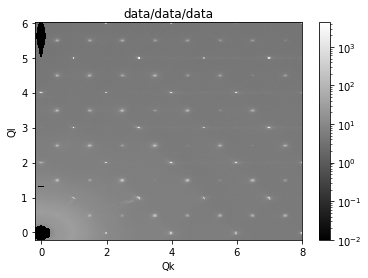

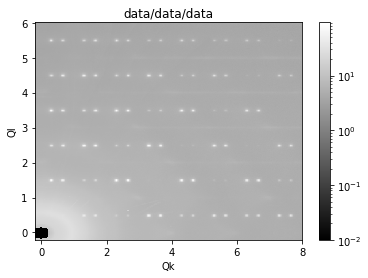

In [4]:
data.entry.symm_transform[-0.2:6.,-0.2:8.,0.0].data.plot(log=True,cmap=plt.cm.gray)
data.entry.symm_transform[-0.2:6.,-0.2:8.,1.0/6].data.plot(log=True, cmap=plt.cm.gray)

In [5]:
# Here we set a "large value" threshold
large_val = 2.65

# Here we set a curvature threshold
upper_curv_thresh = 0.15; lower_curv_thresh = -0.15

# def getbraggs(x,dxx):
#     return np.nonzero((x-np.rint(x))**2<(dxx/2)**2)[0]

## Look at the distribution of the log values in the dataset

In [35]:
z3d = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxvalue # - movo2_40_background.entry.symm_transform[-0.2:6.,-0.2:8.,-0.2:8.].data.nxdata
z3dl = np.log(z3d)
# Truncate the logarithm (simpler)
z3dl[z3dl < 0.0] = 0.0

# Take the laplacian of the data
elevation_mapz = laplace(-z3dl)

<ipython-input-35-fbae52cd96c8>:2: RuntimeWarning: divide by zero encountered in log
  z3dl = np.log(z3d)


<ipython-input-36-5357bdce3868>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxdata[:,:,10]))


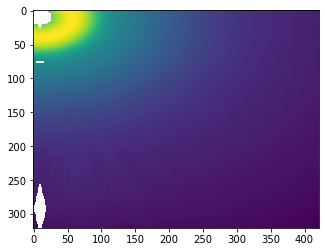

In [36]:
plt.imshow(np.log(movo2_40_background.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxdata[:,:,10]))

(-0.5, 420.5, -0.5, 320.5)

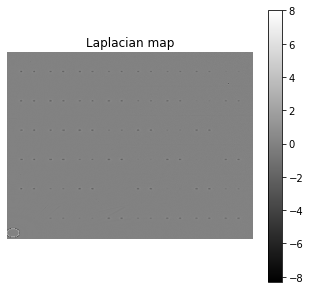

In [37]:
fig, ax = plt.subplots(figsize=(5.5, 5))
c = ax.imshow(elevation_mapz[:,:,20], cmap=plt.cm.gray, origin='lower')
fig.colorbar(c, ax=ax)
ax.set_title('Laplacian map')
ax.axis('off')

## Initialize X, Y, Z and dX, dY, and dZ

In [4]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.,-0.2:8.2,-0.2:8.2].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.,-0.2:8.2,-0.2:8.2].Qh.nxvalue

dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]

## Define the symmetrizing operation and the standard punch

In [39]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)

def symmetrize(res):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background - not
    # rigorously based on anything
    # vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    # vvals[vvals < 0] = 0
    return vvals[0:600,0:800,0:800]

In [40]:
julia.include("/Users/vishwasrao/Research/BES_Project/Repo/laplaceinterpolation/MaternKernelApproximation.jl")

<PyCall.jlwrap Laplace3D_Grid>

In [41]:
# Matern Interpolation happens here.
epsilon = 0.
radius = 0.200;
h = 0.02;
# including the boundaries to see how things work
xmin = 0
xmax = 7
ymin = 0
ymax = 9
zmin = 0
zmax = 9
xbegin = ybegin = zbegin =-0.2
z3d_copy =np.copy(z3d)
z3d_restored = np.copy(z3d)
stride = 10;
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride
    i2 = i1+2*stride+1
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        #print(j1,j2)
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
#             print(int((k-ybegin)/h))
#             print(k2)
#             print(i, j, k)
#             print("\n")
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2]
            restored_img, punched_image = julia.Matern3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp,
                                                              epsilon, radius, h, h, h, 2)
#             print(np.shape(restored_img))
            
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken :", timeit.default_timer() - starttime)

# The result of the Matern interpolation is in z3d_restored

(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)
(9261,)


In [60]:
# Laplace interpolation happens here.
# Interpolated data is in z3d_restored_laplace. Original in z3d.

z3d_copy =np.copy(z3d)
z3d_restored_laplace = np.copy(z3d)
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride
    i2 = i1+2*stride+1
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        #print(j1,j2)
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
            #print(k1,k2)
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2]
            restored_img, punched_image = julia.Laplace3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, radius, h,
                                                              h, h)
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored_laplace[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken :", timeit.default_timer() - starttime)

Time taken : 48.02803764300188


(1e-05, 4175.1025390625)

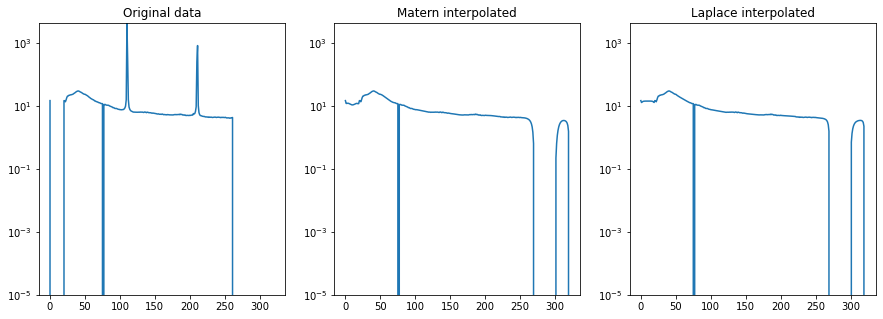

In [98]:
# Taking a 1D slice

# Index in x and y
idx = 9;
idy = 11;

# Find the maximum of the data on the slice common to both z3d_copy and z3d (are these different?) and add 10 for good measure
max1 = np.max(z3d_copy[:,idy,idx])
max2 = np.max(z3d[:,idy,idx])
max_y = np.max([max1, max2])+10

# Plot original data, matern and laplace interpolations
fig,ax=plt.subplots(1,3, figsize=(15,5))
ax[0].semilogy((z3d[:,idy, idx]))
ax[0].set_ylim([0.00001, max_y])
ax[0].set_title("Original data")
ax[1].semilogy((z3d_restored[:, idy,idx]))
ax[1].set_title("Matern interpolated")
ax[1].set_ylim([0.00001, max_y])
ax[2].semilogy((z3d_restored_laplace[:, idy,idx]))
ax[2].set_title("Laplace interpolated")
ax[2].set_ylim([0.00001, max_y])

In [63]:
# do a quick visual error comparison
print(z3d[90:111,60,60] - z3d_restored[90:111,60,60])

[   0.          0.          0.       ...    1.44989     5.391197
 1186.1477  ]


In [69]:
punched, nan_locs = standard_punch(x,x2,x3,z3d,0.2001)

In [70]:
symmetrize(nan_locs).shape 
# Note: this is one smaller in every direction than the original: this is so that one can do an FFT and the data can simply be tiled

ValueError: could not broadcast input array from shape (321,421,421) into shape (311,411,411)

## Save the watershed and standard punch locations to an .nxs file 

In [71]:
expt_data = nxload(save_data_dir + 'movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [72]:
# Save the standard punch locations -- Paths and names of the filenames need to be changed. So commenting
#out the Save command.
root = NXroot(NXentry())
# Make a nexus field for the Standard punch 
stdpunch = NXfield(symmetrize(nan_locs), name='standard_punch_locs')
root.entry.sphere_punch = NXdata(stdpunch, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)
#root.save(save_data_dir + 'punched/new_movo2_40_sphere_punch_locs.nxs')

ValueError: could not broadcast input array from shape (321,421,421) into shape (311,411,411)

# Interpolation step

In [21]:
# Conventional punch and Gaussian fill
%time res = standard_fill(z3d,punched,nan_locs)

CPU times: user 7min 28s, sys: 1.21 s, total: 7min 29s
Wall time: 7min 30s


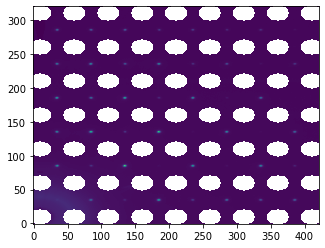

In [73]:
# plt.imshow(res[:,:,10], origin='lower')
plt.imshow(punched[:,:,10], origin='lower')

In [74]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored), name='sphere_punch_matern_interp_data')
root.entry.sphere_matern_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_matern_data.nxs')

ValueError: could not broadcast input array from shape (321,421,421) into shape (311,411,411)

In [24]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored_laplace), name='sphere_punch_laplace_interp_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_laplace_data.nxs')

In [25]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_copy), name='original_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_original_data.nxs')

In [26]:
# Save the standard punch and fill result.
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(res), name='sphere_punch_gauss_interp_data')
root.entry.sphere_gauss_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_gauss_data.nxs')